In [1]:
import sys
print(sys.version)

3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 10:07:17) [Clang 14.0.6 ]


In [20]:
# Importing dependencies

import os
os.environ['PYTHONHASHSEED'] = '0'
import random as rn
import numpy as np
from sklearn.model_selection import GridSearchCV
np.random.seed(1)
rn.seed(3)
### BEGIN CHANGES - KELVIN AND JEEVAN 
### Update Tensor Flow Version.
#from tensorflow import set_random_seed
#set_random_seed(2)
import tensorflow
tensorflow.random.set_seed(2)
### END CHANGES
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, SimpleRNN, Input
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from scikeras.wrappers import KerasRegressor
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

## Dataset Preprocessing and Feature Extraction

In [3]:
# Loading the dataset
url = '../CSV.csv'
df = pd.read_csv(url,parse_dates = True,index_col=0)
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-02-15,19.200001,19.639999,19.180000,19.590000,19.590000,146000
2019-02-19,19.500000,19.600000,19.100000,19.549999,19.549999,138100
2019-02-20,19.660000,20.059999,19.520000,19.920000,19.920000,133400
2019-02-21,19.740000,20.790001,19.530001,20.190001,20.190001,167000
2019-02-22,20.389999,21.080000,20.379999,21.000000,21.000000,434100


<Axes: xlabel='Date'>

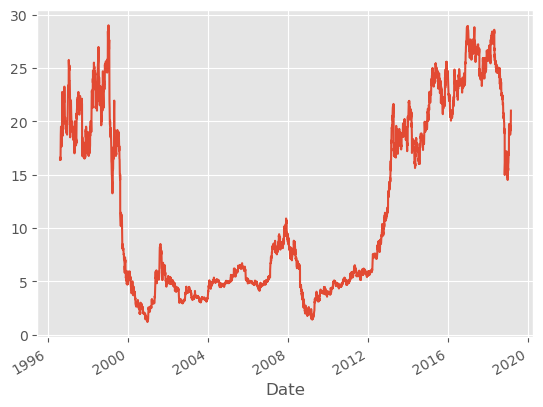

In [4]:
df['Close'].plot()

In [5]:
# Correlation matrix
df.corr()['Close']

Open         0.999440
High         0.999733
Low          0.999712
Close        1.000000
Adj Close    0.999319
Volume       0.237297
Name: Close, dtype: float64

count    5.672000e+03
mean     6.335628e+04
std      8.749770e+04
min      0.000000e+00
25%      1.850000e+04
50%      3.985000e+04
75%      7.900000e+04
max      2.073400e+06
Name: Volume, dtype: float64


<Axes: >

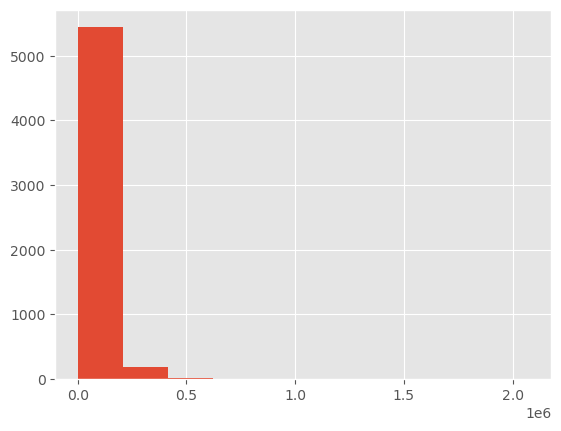

In [6]:
# Distribution of Various Features
print(df.describe().Volume) 
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0
df['Volume'].hist(bins = 10)

In [7]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [24]:
def create_model(X_train, hl, lr):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(SimpleRNN(X_train.shape[2],return_sequences = True,
                        activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(SimpleRNN(hl[i],activation = 'relu',return_sequences = True))
    model.add(SimpleRNN(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(learning_rate=lr), loss = 'mean_squared_error')
    return model

#Build and train the model
def fit_model(train,val,timesteps,hl,lr,param_grid):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = KerasRegressor(model=create_model, 
                           X_train=X_train, 
                           hl=hl, 
                           lr=lr, 
                           verbose=0)
    #print(model.summary())
  
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(X_train, Y_train)
    best_model = grid_result.best_estimator_
    # Training the data
    best_model.fit(X_train,Y_train, validation_data = (X_val, Y_val),
                        verbose = 0, shuffle = False, callbacks=callbacks_list)
    history = best_model.history_

    #model.reset_states()
    return best_model, history['loss'], history['val_loss']
  

In [25]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat
  

In [26]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivatiate-RNN")
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [27]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Loss Plot')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

## Model Building

In [28]:
# Extracting the series
series = df[['Close','High','Volume']] # Picking the multivariate series 
print(series.shape)
print(series.tail())

(5670, 3)
                Close       High  Volume
Date                                    
2019-02-15  19.590000  19.639999  146000
2019-02-19  19.549999  19.600000  138100
2019-02-20  19.920000  20.059999  133400
2019-02-21  20.190001  20.790001  167000
2019-02-22  21.000000  21.080000  434100


In [29]:
# Train Val Test Split
train_start = dt.date(1997,1,1)
train_end = dt.date(2006,12,31)
train_data = series.loc[train_start:train_end]

val_start = dt.date(2007,1,1)
val_end = dt.date(2008,12,31)
val_data = series.loc[val_start:val_end]

test_start = dt.date(2009,1,1)
test_end = dt.date(2010,12,31)
test_data = series.loc[test_start:test_end]

print(train_data.shape,val_data.shape,test_data.shape)

(2515, 3) (504, 3) (503, 3)


In [30]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(2515, 3) (504, 3) (503, 3)


In [31]:
timesteps = 30
hl = [50,45]
lr = 1e-3
batch_size = [20, 32, 64]
num_epochs = [50, 200]
param_grid = dict(batch_size=batch_size, epochs=num_epochs)

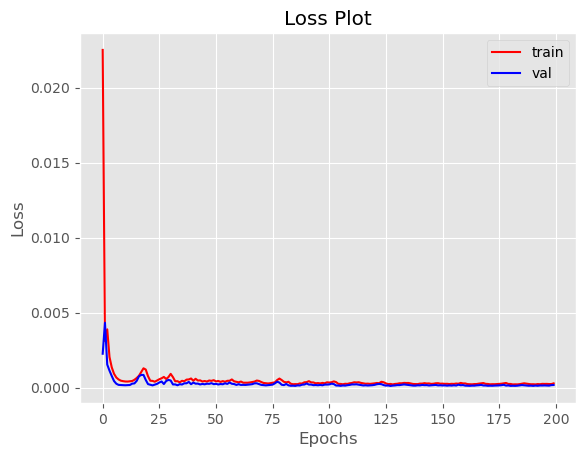

In [32]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,param_grid)
plot_error(train_error,val_error)

MSE = 4.938249664339737e-05
RMSE = 0.007027268078236191
R-Squared Score = 0.9584419347101096


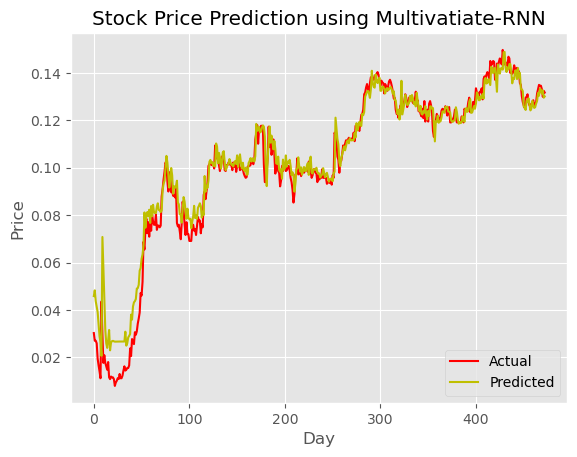

In [33]:
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,30)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

In [35]:
# Save a model
model.model_.save('MV3-RNN_30_[50,45]_1e-3_32-Grid.keras')
del model # Deletes the model
# Load a model
#model = load_model('model_simple_30_[50,45]_1e-3_32.h5')

## Cross Validation

In [36]:
# Hyperparameters
timesteps = 30
hl = [50,45]
lr = 1e-3
batch_size = 32
num_epochs = 50

In [37]:
# Extracting the series
series = df[['Close','High','Volume']] # Picking the multivariate series 
print(series.shape)
print(series.tail())

(5670, 3)
                Close       High  Volume
Date                                    
2019-02-15  19.590000  19.639999  146000
2019-02-19  19.549999  19.600000  138100
2019-02-20  19.920000  20.059999  133400
2019-02-21  20.190001  20.790001  167000
2019-02-22  21.000000  21.080000  434100


In [38]:
# Normalisation
sc = MinMaxScaler()
series = sc.fit_transform(series[:5400])
series

array([[0.5505618 , 0.55257271, 0.77239184],
       [0.5505618 , 0.55257271, 0.1257898 ],
       [0.54606742, 0.55257271, 0.07847393],
       ...,
       [0.91406745, 0.90693512, 0.02585251],
       [0.93204498, 0.92769575, 0.08074085],
       [0.92737079, 0.92841163, 0.09197897]])

### Split I

In [39]:
#Splitting the data for initial model creation
splits = 5
split_size = 600
train = series[:3*split_size]
test = series[3*split_size:4*split_size]

Split 1
MSE = 0.0002400351484087982
RMSE = 0.015493067753314648
R-Squared Score = 0.6625013942410753


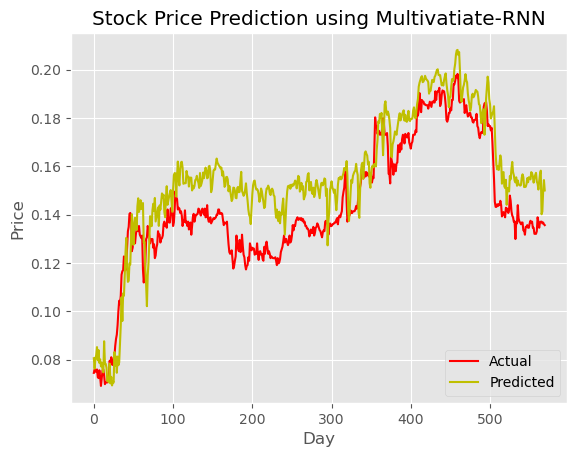

In [41]:
cross_val_results = list()
train_loss = pd.DataFrame()
val_loss = pd.DataFrame()
model,train_error,val_error = fit_model(train,test, timesteps,hl,lr,param_grid)
train_loss['Split1'] = train_error
val_loss['Split1'] = val_error
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 1")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,0])
model.model_.save("MV3-RNN-Split1-Grid.keras")

### Split II

Split 2
MSE = 0.0008069541823119595
RMSE = 0.028406938981734013
R-Squared Score = 0.8071973929591245


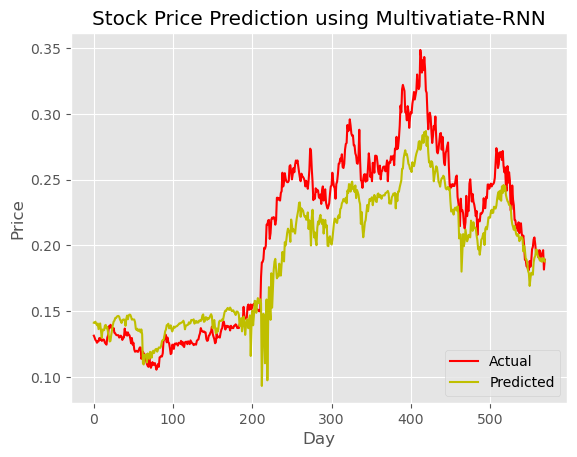

In [42]:
train = series[:4*split_size]
test = series[4*split_size:5*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split2"] = history.history_['loss']
val_loss["Split2"] = history.history_['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 2")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.model_.save("MV3-RNN-Split2-Grid.keras")

### Split III

Split 3
MSE = 0.00010693275986894156
RMSE = 0.01034082974760447
R-Squared Score = 0.9277491643270344


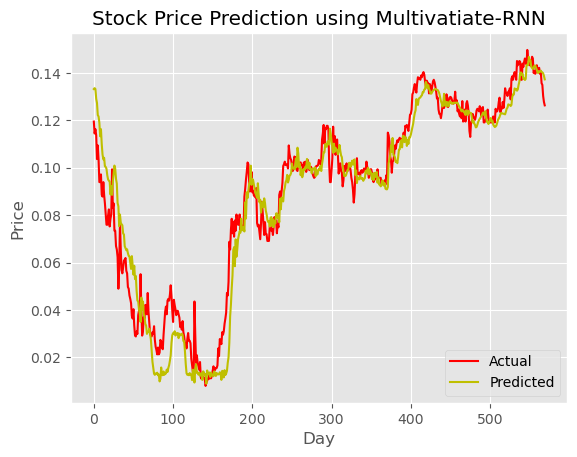

In [43]:
train = series[:5*split_size]
test = series[5*split_size:6*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split3"] = history.history_['loss']
val_loss["Split3"] = history.history_['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 3")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.model_.save("MV3-RNN-Split3-Grid.keras")

### Split IV

Split 4
MSE = 0.00010971986641494674
RMSE = 0.010474725123598554
R-Squared Score = 0.9944940310776923


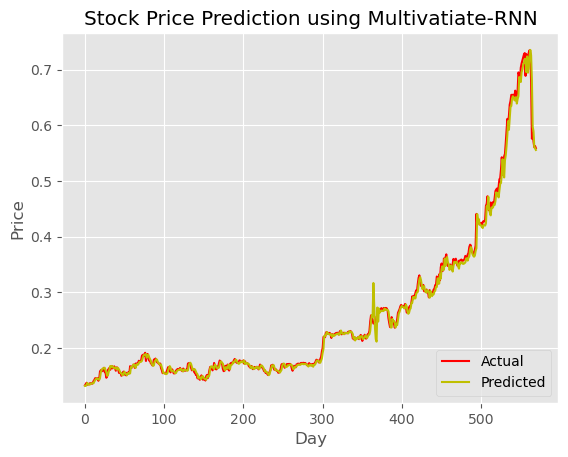

In [44]:
train = series[:6*split_size]
test = series[6*split_size:7*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split4"] = history.history_['loss']
val_loss["Split4"] = history.history_['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 4")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.model_.save("MV3-RNN-Split4-Grid.keras")

### Split V

Split 5
MSE = 0.0033796260176481574
RMSE = 0.05813455098001667
R-Squared Score = 0.6105183158967826


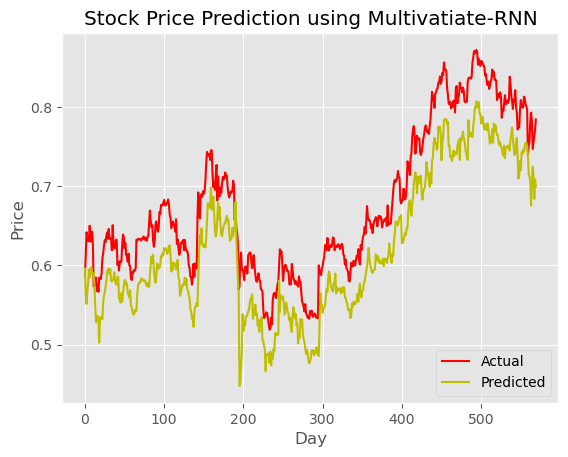

In [45]:
train = series[:7*split_size]
test = series[7*split_size:8*split_size]
X_train,Y_train = [],[]
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

start = time.time()
history = model.fit(X_train,Y_train,validation_split = 0.2,verbose = 0,
                    shuffle = False)
end = time.time()   
train_loss["Split5"] = history.history_['loss']
val_loss["Split5"] = history.history_['val_loss']
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print("Split 5")
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)
cross_val_results.append([mse,rmse,r2_value,end-start])
model.model_.save("MV3-RNN-Split5-Grid.keras")

In [46]:
CV_results = pd.DataFrame(cross_val_results,columns=['MSE','RMSE','R2_Score','Train_Time'])
print("Avg. MSE = {}".format(CV_results['MSE'].mean()))
print("Avg. RMSE = {}".format(CV_results['RMSE'].mean()))
print("Avg. R2-score = {}".format(CV_results['R2_Score'].mean()))

Avg. MSE = 0.0009286535949305606
Avg. RMSE = 0.02457002251725367
Avg. R2-score = 0.800492059700342


In [47]:
CV_results.to_csv('MV3-RNN_CrossValidation-Grid.csv')
train_loss.to_csv('MV3-RNN_CrossValidation_TrainLoss-Grid.csv')
val_loss.to_csv('MV3-RNN_CrossValidation_ValLoss-Grid.csv')